<a href="https://colab.research.google.com/github/GalileoCap/network/blob/main/networkx_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

My electrical network is composed of:
Central -> States -> Cities -> Neighborhood -> Blocks -> Houses  
I'm also assuming they all have Normal Distributions

In [ ]:
#_Dists = [(1, 0), (5, 1.3), (15, 10), (14, 4), (40, 25), (40, 5)]
_Dists = [(1, 0), (5, 1.3), (3, 1), (4, 0.2), (5, 2), (8, 1)]
#U: A tuple for each level with (mu, sigma^2)
#TODO: Check if numpy uses sigma or sigma^2

In [ ]:
def normal(n = 1, dist = (0, 1)): #U: Sample of n positive integers
  return list(np.floor(np.abs(np.random.normal(dist[0], dist[1], n))))
#TODO: Check mean and distribution

def lr(i, dist): #U: A list of integers from i to i+random
  return list(range(i, int(normal(1, dist)[0]+i)))

In [ ]:
def gen_data(parent, pos, depth, dists): #U: A list of nodes and edges
  nodes = lr(pos, dists[depth]) #A: New children
  other_nodes = [] #A: Children of children
  edges = []
  for node in nodes:
    edges.append((parent, node)) #A: Connect this child to parent
    if (depth < len(dists)-1): #A: It's not a leaf
      next = gen_data(node, pos+len(nodes)+len(other_nodes), depth+1, dists)
      #A: Generate children for this node starting from pos (without overlapping ID's)
      other_nodes += next[0]
      edges += next[1]

  return (nodes + other_nodes, edges)
#TODO: Save a dictionary with a list of id's per type
#TODO: Pasar a declarativo.
# Tengo una distribucion de grados para cada nivel
# quiero generar un grafo dirigido que cumpla con esas distribuciones
# 
# Mire si Networkx ya lo hacia, y no hay ninguna funcion
# Tengo que fabricar una lista de links usando numpy
#  Agarro la raiz y genero n hijos
#  devuelvo el ultimo hijo
#  y a cada hijo le genero sus m hijos...

In [ ]:
def gen_graph(dists = _Dists):
  data = gen_data(0, 1, 1, dists)

  res = nx.Graph()
  res.add_nodes_from([0] + data[0])
  res.add_edges_from(data[1])

  return res

G = gen_graph()

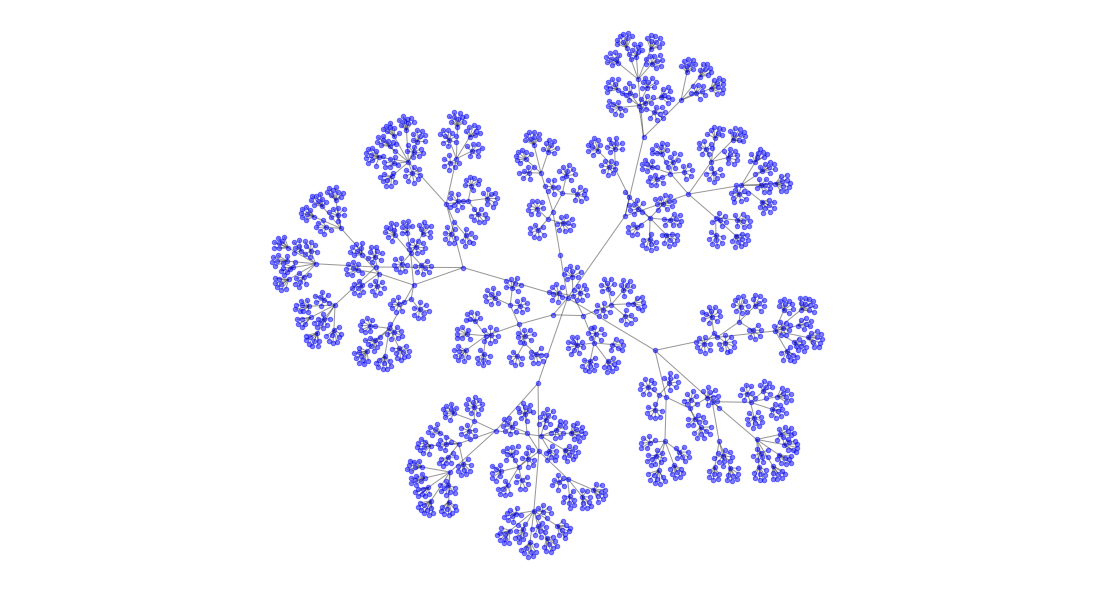

In [ ]:
pos = graphviz_layout(G, prog='sfdp')
plt.figure(figsize=(15, 8))
nx.draw(G, pos, 
        node_size=20, alpha=0.5, node_color="blue", font_size=6, font_color='black', edge_color='#303030')
plt.axis('equal')
plt.show()



---

# Histogramas y análisis

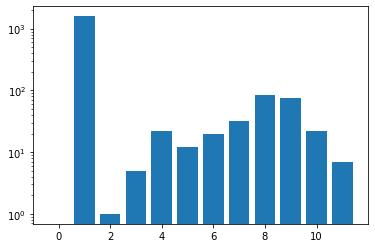

In [ ]:
x= nx.degree_histogram(G)
plt.bar(range(len(x)),x, log=True)
plt.show()



---

# Proximos pasos



*   Limpiar, documentar y ordenar
*   Estadisticas y gráficos (de grado, etc.)
* Usar arrays homogeneos de numpy y networkx, y list comprehensions






## Usar generadores

https://networkx.org/documentation/stable/reference/generated/networkx.generators.classic.full_rary_tree.html#networkx.generators.classic.full_rary_tree

* Aprender a generar arrays con numpy y transformarlos sin descomponerlo elemento por elemento (estilo declarativo)
* Aprender a usar los algoritmos de networkx (k-cores, º



---

# SimCity

* Para cada tipo cuantos children de cada tipo y con qué probabilidad

In [ ]:
Cfg = {
    'estacion': [{
        'tipo': 'feeder',
        'min': 2,
        'max': 4
    }],
    'feeder': [{
        'tipo': 'trafo_bt',
        'min': 1,
        'max': 2
    }],
    'trafo_bt': [{
        'tipo': 'cable',
        'min': 1,
        'max': 5
    }],
    'cable': [{
        'tipo': 'suministro',
        'min': 1,
        'max': 3
    }, {
        'tipo': 'cable',
        'min': 0,
        'max': 2
    }]
}

In [ ]:
seed = 0 #A non-negative integer
_RNG = np.random.default_rng(seed) #U: Random number generator

In [ ]:
IDs = itertools.count()

def gen_para(tipo, parent = next(IDs)):
  ch_types = Cfg.get(tipo)
  if ch_types == None:
    return []
  #A: Tengo una definicion para este tipo
  return list(itertools.chain.from_iterable([
    [( # Este elemento
        ch_type['tipo'], #Tipo, ej: cable
        (parent, ch_id)
    )]
      + gen_para(ch_type['tipo'], ch_id) # Children
    
    for ch_type in ch_types
    for ch_idx in range(_RNG.integers(ch_type['min'], ch_type['max']+1)) #cnt
    for ch_id in [next(IDs)] #Child id
  ]))

In [ ]:
red = gen_para('estacion')
len(red)

2813

In [ ]:
G = nx.DiGraph()
G.add_edges_from([element[1] for element in red])
labels = {element[1][1]:element[0][0] for element in red}
labels[0] = 'e'

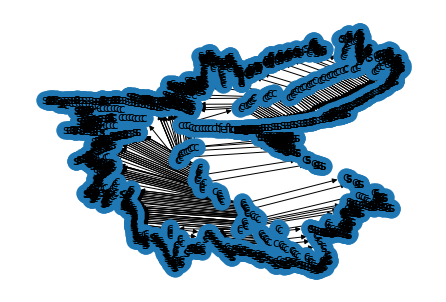

In [ ]:
pos = graphviz_layout(G, prog='twopi')
plt.figure(figsize=(15, 8))

nx.draw(G, pos, labels = labels)

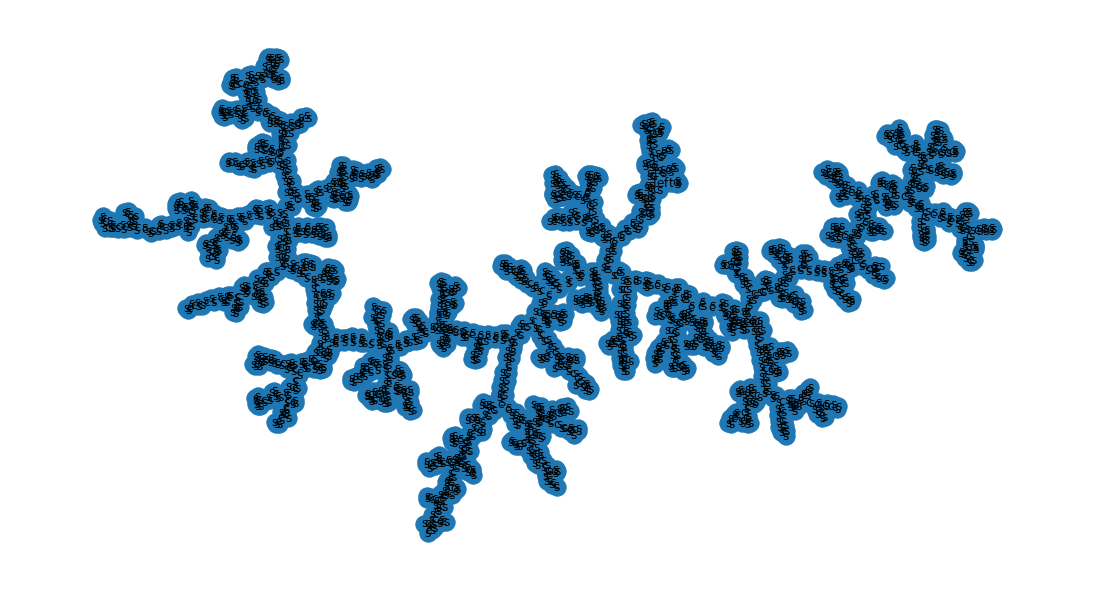

In [ ]:
pos = graphviz_layout(G, prog='sfdp')
plt.figure(figsize=(15, 8))

nx.draw(G, pos, labels = labels)



---

# Proximos pasos

* Histograma de grados de salida por tipo
* Otras estadisticas (cuantos elementos de cada tipo, cable más largo, cable con más suministros (siguiendo la linea), ...)
* Si se rompe un elemento cualquiera cuantas casas se quedan sin luz
* Agregarle (x, y) a los elementos, y calcular distancia entre cosas (máxima y minima, si hay subestaciones muy cerca, postes muy lejos, ...)
* SimCity (romper, que la gente llamó, lo arreglamos x horas después,...)